In [47]:
from scipy import misc
import os.path
#find nearest pixel
from scipy import spatial
from scipy.ndimage.filters import gaussian_filter1d
import nibabel as nb
import numpy as np
import skfmm
from matplotlib import pyplot as plt
from skimage.draw import line
from PIL import Image
Image.MAX_IMAGE_PIXELS = 472700252
#function to calculate distance along path
def calculate_path_distance(mask,seed):
  """calculate wmdistances from seed voxel to all other wm voxels"""
  mask.data[seed[0],seed[1]]=0
  mask.mask[seed[0],seed[1]]=False
  wmdistances=skfmm.distance(mask)
  return wmdistances;

#convert binary to appropriate mask
def convert2mask(wm_mask):
  """convert tissue classification into correct format for skfmm distance function"""
  Base=np.ones_like(wm_mask)
  mask=~wm_mask.astype(bool)
  input_mask=np.ma.masked_array(Base,mask)
  return input_mask;

def colour2mask(im,colour):
    """create mask from specific colour (and nearby colours)"""
    bin=np.zeros(np.shape(im)[0:2])
    bin[im==colour]=1
    return bin;

def shrink_coordinates(coords,idx, size):
    """shrink coordinate data set for search within +/- size"""
    shrink=coords[np.logical_and(coords[:,0]>=idx[0]-size,
        np.logical_and(coords[:,0]<=idx[0]+size,
        np.logical_and(coords[:,1]>=idx[1]-size,
        coords[:,1]<=idx[1]+size)))]
    return shrink;

def crop_image(image):
    y,x=np.where(image!=0)
    min_y = np.min(y)-500
    max_y = np.max(y)+500
    min_x = np.min(x)-500
    max_x = np.max(x)+500
    image= image[min_y:max_y,min_x:max_x]
    return image, min_x, min_y



In [118]:

#profile separation is ~ 1 pixel in 20um space
profile_separation=2
resolution=0.005
smoothing_level=5
#expansion beyong L1/white surface 
expansions=[50,100,150]
layer1=1#red
layer4=5#pink
white_c=7#blue


Slices=['1582','1600','3380','4080','5431','6316']
Slices=['3380']
Regions=['1','2','7','8']
for Slice in Slices:
    for Region in Regions:
      if os.path.isfile('/data1/users/kwagstyl/bigbrain/Slice_Verification/new_sections_03-18/Slice_'+Slice+'/Region'+Region+'_alllines.tif'):        
        print('running Slice: ' + Slice+ ' Region:' + Region)
        whitename='Slice_'+Slice+'/Region_'+Region+'_coordinates_white.txt'
        grayname='Slice_'+Slice+'/Region_'+Region+'_coordinates_gray.txt'
        im=misc.imread('/data1/users/kwagstyl/bigbrain/Slice_Verification/new_sections_03-18/Slice_'+Slice+'/Region'+Region+'_alllines.tif')
#get mask of just layer 4
        #crop image due to memory problems
        im,crop_x,crop_y = crop_image(im)
        L4=colour2mask(im,layer4)

        L4y,L4x=np.where(L4==1)
#get mask of just layer 1
        L1=colour2mask(im,layer1)
        dumy,dumx=np.where(L1==1)
        L1coords=np.transpose(np.vstack([dumy,dumx]))
#get mask of just white
        white=colour2mask(im,white_c)
        dumy,dumx=np.where(white==1)
        whitecoords=np.transpose(np.vstack([dumy,dumx]))
        seed=[L4y[0],L4x[0]]
        mask=convert2mask(L4)
        distances=calculate_path_distance(mask,seed)
        start_index=np.unravel_index(np.argmax(distances),np.shape(distances))
        mask=convert2mask(L4)
        distances=calculate_path_distance(mask,start_index)
#set masked out values to huge so that they're never sampled
        distances.data[distances.mask]=100000000000
        fardistance=np.max(distances)
#create vector of steps along line eg 0, 10, 20, 30, 
        distance_steps=np.arange(0,fardistance,profile_separation)
        L1distance,L1index = spatial.KDTree(L1coords).query(start_index)
        Wdistance,Windex = spatial.KDTree(whitecoords).query(start_index)
        imline=im[:]
        L1_exp=np.zeros([len(distance_steps),2])
        White_exp=np.zeros([len(distance_steps),2])
        indices=np.zeros([len(distance_steps),2])
        AllNormVectors=np.zeros([len(distance_steps),2])
        L1distance=np.zeros([len(distance_steps),1])
        Wdistance=np.zeros([len(distance_steps),1])
        idx=start_index
        print("generating profile lines...")
        for c,step in enumerate(distance_steps):
    #shrink search area for speed
            search=np.int(np.round(profile_separation*1.5))
            tmp=distances.data[idx[0]-search:idx[0]+search,idx[1]-search:idx[1]+search]
    #search for next start index, closest to distance step
            tmpidx = np.unravel_index(np.argmin(np.abs(tmp - step)),np.shape(tmp))
            #reset coordinates
            idx=tmpidx+np.array([idx[0]-search,idx[1]-search])
            indices[c]=idx
    #shrink L1 and white coords for search
            tmpL1=shrink_coordinates(L1coords,idx,700)
            L1distance[c],L1index = spatial.KDTree(tmpL1).query(idx)
            tmpwhite=shrink_coordinates(whitecoords,idx,700)
            Wdistance[c],Windex = spatial.KDTree(tmpwhite).query(idx)
   # find vector between nearest white/L1 coordinates
            Vec=tmpL1[L1index]-tmpwhite[Windex]
  #  normalise
            AllNormVectors[c]=Vec/np.linalg.norm(Vec)
            perc=(float(c)/len(distance_steps))*100.0
            if perc % 10==0:
                print(str(perc)+'% complete')
        print(tmp)
        Coordinates=[[0]]
        SmoothNormVectors=gaussian_filter1d(AllNormVectors,smoothing_level,axis=0)
        SmoothNormVectors=SmoothNormVectors/np.linalg.norm(SmoothNormVectors,axis=1).reshape([len(SmoothNormVectors),1])
        for gexpansion in expansions:
            for wexpansion in expansions:
                L1_exp=np.round(SmoothNormVectors*(L1distance+gexpansion)+indices).astype(int)
                White_exp=np.round(SmoothNormVectors*-(Wdistance+wexpansion)+indices).astype(int)
                if Coordinates[0][0] == 0:
                    Coordinates=np.hstack([L1_exp,White_exp])
                else:
                    Coordinates=np.hstack([Coordinates,np.hstack([L1_exp,White_exp])])
        Coordinates=np.reshape(Coordinates,(np.size(Coordinates)//4,4))
        break
        if crop_x:
            Coordinates=Coordinates+np.array([crop_y,crop_x,crop_y,crop_x])
            
        Slicepng='Slice_'+Slice+'/Slice'+Slice+'.mnc'
        image=nb.load(Slicepng)
        dum,leny,lenx=np.shape(image.get_data())
        xstart=0.5*lenx*resolution
        ystart=-0.5*leny*resolution
#invert y
        Coordinates=np.vstack((-Coordinates[:,0],Coordinates[:,1],-Coordinates[:,2],Coordinates[:,3])).transpose()
        
#change step size
        Coordinates=Coordinates*resolution
        Coordinates=Coordinates-np.array([ystart,xstart,ystart,xstart])



running Slice: 3380 Region:1


/home/users/kwagstyl/anaconda3/envs/profiletools/lib/python2.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


generating profile lines...
0.0% complete
[[2.28568451e+03 2.28661473e+03 1.00000000e+11 1.00000000e+11
  1.00000000e+11 1.00000000e+11]
 [2.28632183e+03 2.28711249e+03 2.28804270e+03 1.00000000e+11
  1.00000000e+11 1.00000000e+11]
 [2.28711249e+03 2.28774981e+03 2.28854046e+03 2.28947068e+03
  1.00000000e+11 1.00000000e+11]
 [2.28804270e+03 2.28854046e+03 2.28917779e+03 2.28996844e+03
  2.29089866e+03 1.00000000e+11]
 [1.00000000e+11 2.28947068e+03 2.28996844e+03 2.29060576e+03
  2.29139641e+03 2.29232663e+03]
 [1.00000000e+11 1.00000000e+11 2.29089865e+03 2.29139641e+03
  2.29203374e+03 2.29282439e+03]]


<IPython.core.display.Javascript object>


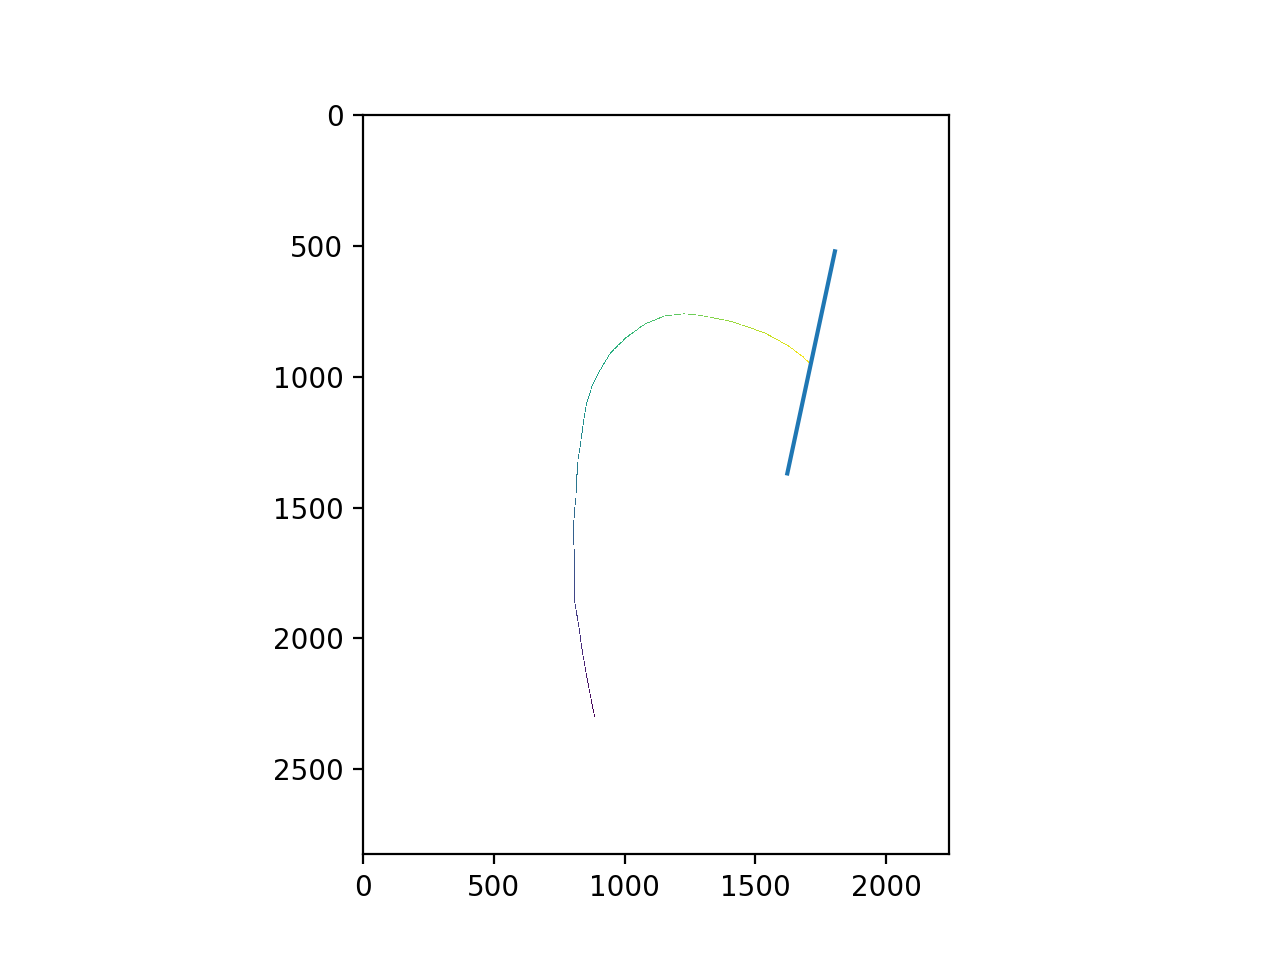

(array([2332,  585]), array([2278, 1103]))
(array([2332,  585]), array([2273, 1153]))
(array([2332,  585]), array([2268, 1203]))
(array([2337,  535]), array([2278, 1103]))
(array([2337,  535]), array([2273, 1153]))
(array([2337,  535]), array([2268, 1203]))
(array([2342,  485]), array([2278, 1103]))
(array([2342,  485]), array([2273, 1153]))
(array([2342,  485]), array([2268, 1203]))


In [121]:
%matplotlib notebook
plt.figure()
im,crop_x,crop_y = crop_image(im)
plt.imshow(distances)
Coordinates=[[0]]
for gexpansion in expansions:
            for wexpansion in expansions:
                L1_exp=np.round(SmoothNormVectors*(L1distance+gexpansion)+indices).astype(int)
                White_exp=np.round(SmoothNormVectors*-(Wdistance+wexpansion)+indices).astype(int)
                print(L1_exp[0],White_exp[0])
                if Coordinates[0][0] == 0:
                    Coordinates=np.hstack([L1_exp,White_exp])
                else:
                    Coordinates=np.hstack([Coordinates,np.hstack([L1_exp,White_exp])])
Coordinates=np.reshape(Coordinates,(np.size(Coordinates)//4,4))
#for profile in Coordinates:
#    plt.plot([profile[1],profile[0]],[profile[3],profile[2]])

#plt.scatter(L1_exp[0,1],L1_exp[0,0])
#plt.scatter(White_exp[0,1],White_exp[0,0])

#plt.scatter(indices[0,1],indices[0,0])
#for Coordinate in Coordinates:
#    plt.plot([Coordinate[1],Coordinate[3]],[Coordinate[0],Coordinate[2]])
#for index in indices:
#    plt.scatter(index[1],index[0])
Coordinate=Coordinates[-1]
plt.plot([Coordinate[1],Coordinate[3]],[Coordinate[0],Coordinate[2]])

[6601, 207, 6601, 207]


<IPython.core.display.Javascript object>


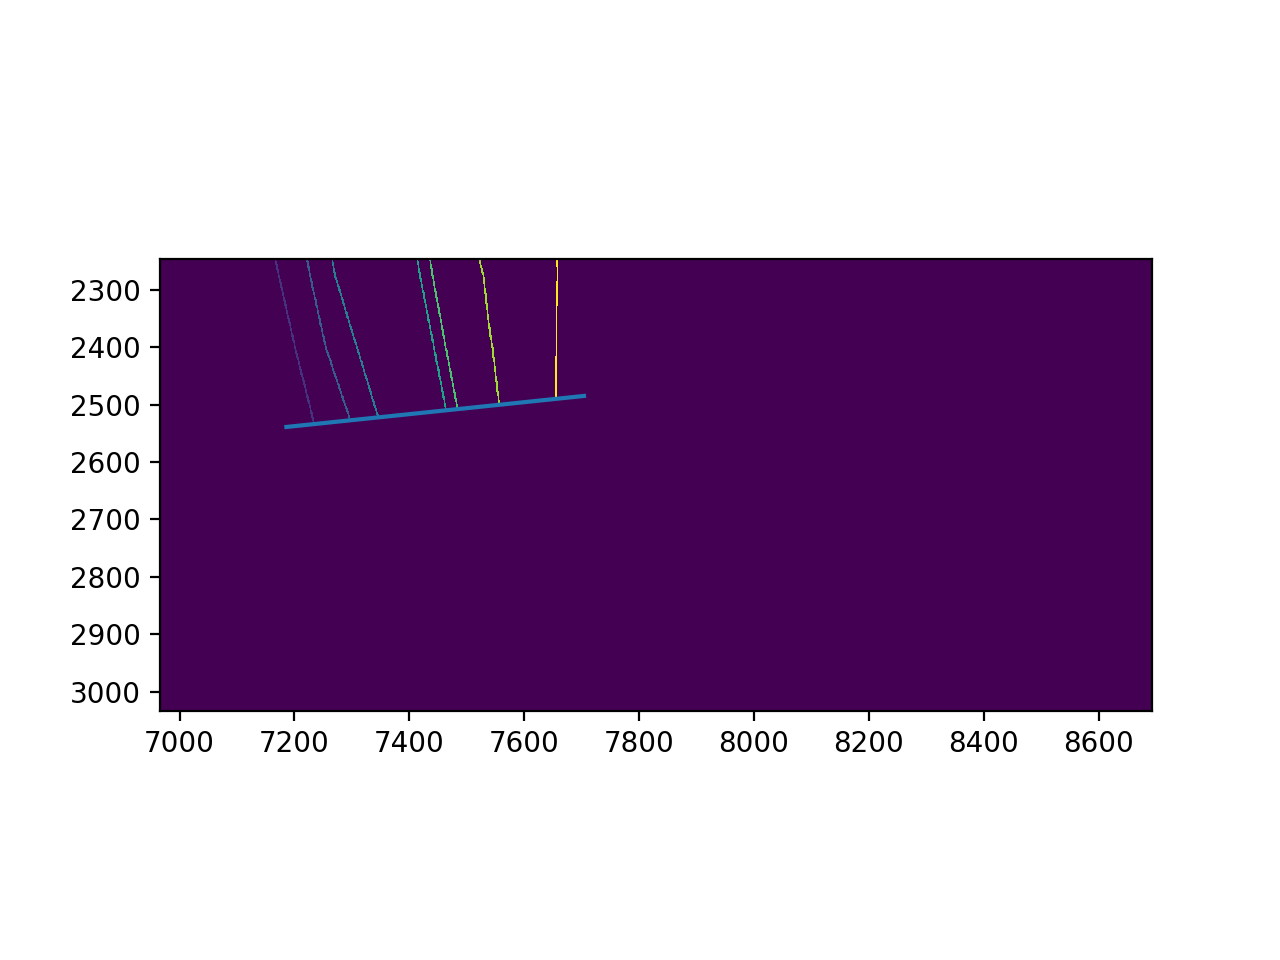

/home/users/kwagstyl/anaconda3/envs/profiletools/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


In [122]:
print([crop_x,crop_y,crop_x,crop_y])
Coordinates=Coordinates+np.array([crop_y,crop_x,crop_y,crop_x])
plt.figure()
im=misc.imread('/data1/users/kwagstyl/bigbrain/Slice_Verification/new_sections_03-18/Slice_'+Slice+'/Region'+Region+'_alllines.tif')
#get mask of just layer 4
plt.imshow(im)
plt.plot([Coordinates[0,1],Coordinates[0,3]],[Coordinates[0,0],Coordinates[0,2]])



In [34]:
[Coordinates[0,1],Coordinates[0,0]],[Coordinates[0,3],Coordinates[0,2]]

([-37, 1039], [352, 1486])

In [71]:
indices[0,1]

884.0

In [30]:
Coordinates=Coordinates+np.array([crop_x,crop_y,crop_x,crop_y])

In [31]:
[Coordinates[0,1],Coordinates[0,0]],[Coordinates[0,3],Coordinates[0,2]]

([804, 3635], [1193, 4082])

In [37]:
np.array([crop_x,crop_y,crop_x,crop_y])

array([0, 0, 0, 0])

In [50]:
start_index

(1776, 668)

In [57]:
indices

array([[2301.,  884.],
       [2299.,  884.],
       [2297.,  884.],
       ...,
       [ 786., 1373.],
       [ 786., 1374.],
       [ 786., 1375.]])